# Custom training: basics

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
      pass
import tensorflow as tf

## Variables

Tensors in TensorFlow are immutable stateless objects. Machine learning models, however, must have changing state: as your model trains, the same code to compute predictions should behave differently over time (hopefully with a lower loss!). To represent this state, which needs to change over the course of your computation, you can choose to rely on the fact that Python is a stateful programming language:

In [2]:
# Using python state
x = tf.zeros([10,10])
x += 2

In [3]:
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


TensorFlow has stateful operations built-in, and these are often easier than using low-level Python representations for your state. Use `tf.Variable` to represent weights in a model.

A `tf.Variable` object stores a value and implicitly reads from this stored value. There are operations (`tf.assign_sub`, `tf.scatter_update`, etc.) that manipulate the value stored in a TensorFlow variable.

In [4]:
v = tf.Variable(1.0)
# Use python assert as a debugging statement to test the condition
assert v.numpy()==1.0

# Reassign the value of v
v.assign(2.0)
assert v.numpy() == 2.0

# Use `v` in a TensorFlow `tf.square()` operation and reassign
v.assign(tf.square(v))
assert v.numpy() == 4.0

Computations using `tf.Variable` are automatically traced when computing gradients. For variables that represent embeddings, TensorFlow will do sparse updates by default, which are more computation and memory efficient.

A `tf.Variable` is also a way to show a reader of your code that a piece of state is mutable.

## Fit a linear model

Let's use the concepts you have learned so far—`Tensor`, `Variable`, and `GradientTape`—to build and train a simple model. This typically involves a few steps:

1. Define the model.
2. Define a loss function.
3. Obtain training data.
4. Run through the training data and use an "optimizer" to adjust the variables to fit the data.

Here, you'll create a simple linear model, `f(x) = x * W + b`, which has two variables: `W` (weights) and `b` (bias). You'll synthesize data such that a well trained model would have `W = 3.0` and `b = 2.0`.

### Define the model

Let's define a simple class to encapsulate the variables and the computation:

In [5]:
class Model(object):
    def __init__(self):
        self.W = tf.Variable(5.0)
        self.b = tf.Variable(0.0)
    def __call__(self,x):
        return self.W*x+self.b

model = Model()
assert model(3.0).numpy() == 15.0

### Define a loss function

A loss function measures how well the output of a model for a given input matches the target output. The goal is to minimize this difference during training. Let's use the standard L2 loss, also known as the least square errors:

In [6]:
def loss(predicted_y,target_y):
    return tf.reduce_mean(tf.square(predicted_y-target_y))

### Obtain training data

First, synthesize the training data by adding random Gaussian (Normal) noise to the inputs:

In [7]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000
inputs = tf.random.normal(shape=[NUM_EXAMPLES])
noise = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs*TRUE_W+TRUE_b+noise

Before training the model, visualize the loss value by plotting the model's predictions in red and the training data in blue:

In [8]:
import matplotlib.pyplot as plt

plt.plot(figsize=(10,7))
plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: %1.6f' % loss(model(inputs), outputs).numpy())

<Figure size 640x480 with 1 Axes>

Current loss: 9.560630


### Define a training loop

With the network and training data, train the model using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) to update the weights variable (`W`) and the bias variable (`b`) to reduce the loss. There are many variants of the gradient descent scheme that are captured in `tf.train.Optimizer`—our recommended implementation. But in the spirit of building from first principles, here you will implement the basic math yourself with the help of `tf.GradientTape` for automatic differentiation and `tf.assign_sub` for decrementing a value (which combines `tf.assign` and `tf.sub`):

In [9]:
def train(model,inputs,outputs,learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs),outputs)
    dw,db = t.gradient(current_loss,[model.W,model.b])
    model.W.assign_sub(learning_rate*dw)
    model.b.assign_sub(learning_rate*db)

In [10]:
model.W.numpy()
model.b.numpy()

0.0

Finally, let's repeatedly run through the training data and see how `W` and `b` evolve.

Epoch  0: W=5.00 b=0.00, loss=9.56063
Epoch  1: W=4.96 b=0.04, loss=9.20934
Epoch  2: W=4.92 b=0.08, loss=8.87243
Epoch  3: W=4.88 b=0.13, loss=8.54930
Epoch  4: W=4.84 b=0.17, loss=8.23939
Epoch  5: W=4.80 b=0.21, loss=7.94216
Epoch  6: W=4.76 b=0.24, loss=7.65709
Epoch  7: W=4.73 b=0.28, loss=7.38368
Epoch  8: W=4.69 b=0.32, loss=7.12146
Epoch  9: W=4.66 b=0.36, loss=6.86996


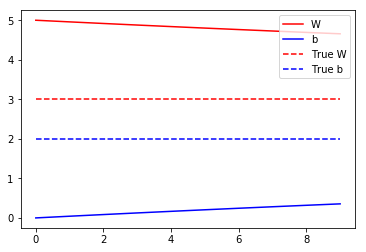

In [11]:
model = Model()
#collect the history of w-values and b-values to plot later
ws,bs = [],[]
epochs = range(10)
for epoch in epochs:
    ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(model(inputs), outputs)
    
    train(model,inputs,outputs,learning_rate = 0.01)
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, ws[-1], bs[-1], current_loss))
    
# Let's plot it all
plt.plot(epochs, ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'True W', 'True b'])
plt.show()